# Model

This is a reimplementation of <a href="https://www.kaggle.com/harupy/m5-baseline">this Kaggle notebook</a>.

## Set-up

In [1]:
import gc

import IPython
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

/opt/anaconda3/envs/lightgbm/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)
plt.rcParams['figure.figsize'] = (12, 8)
register_matplotlib_converters()

## Helper functions

In [3]:
def display(*dfs, head=True):
    for df in dfs:
        IPython.display.display(df.head() if head else df)

In [4]:
def reduce_mem_usage(df, verbose=True):
    if verbose:
        start_mem = df.memory_usage().sum() / 1024**2
        print('~> Memory usage of dataframe is {:.3f} MG'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int' or np.all(np.mod(df[col], 1) == 0):
                # Booleans mapped to integers
                if list(df[col].unique()) == [1, 0]:
                    df[col] = df[col].astype(bool)
                elif c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
             pass

    if verbose:
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('~> Memory usage after optimization is: {:.3f} MG'.format(end_mem))
        print('~> Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('---' * 20)
    return df

# Load Data

In [5]:
def read_data():
    INPUT_DIR = "data"

    print("Reading files...")

    data = pd.read_csv(f"{INPUT_DIR}/processed.csv").pipe(
        reduce_mem_usage
    )
    submission = pd.read_csv(f"{INPUT_DIR}/sample_submission.csv").pipe(
        reduce_mem_usage
    )

    return data, submission

In [6]:
data, submission = read_data()

NUM_ITEMS = 30490
DAYS_PRED = 28
day_col = "d"
dt_col = "date"

data.sample(10)

Reading files...
~> Memory usage of dataframe is 8672.315 MG
~> Memory usage after optimization is: 2274.357 MG
~> Decreased by 73.8%
------------------------------------------------------------
~> Memory usage of dataframe is 13.492 MG
~> Memory usage after optimization is: 2.094 MG
~> Decreased by 84.5%
------------------------------------------------------------


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,shift_t28,shift_t29,shift_t30,rolling_std_t7,rolling_std_t30,rolling_std_t60,rolling_std_t90,rolling_std_t180,rolling_mean_t7,rolling_mean_t30,rolling_mean_t60,rolling_mean_t90,rolling_mean_t180,rolling_min_t7,rolling_min_t30,rolling_min_t60,rolling_max_t7,rolling_max_t30,rolling_max_t60,rolling_skew_t30,rolling_kurt_t30,price_change_t1,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,week,day,dayofweek,is_weekend
22049423,HOBBIES_1_241_TX_2_validation,1670,3,1,5,1,1934,0,validation,2016-05-15,11616,NaN,NaN,NaN,NaN,0,1,1,19.937500,0.0,1.0,1.0,0.488037,0.994141,1.009766,0.970215,0.895020,0.285645,0.666504,0.783203,0.811035,0.794434,0.0,0.0,0.0,1.0,4.0,4.0,1.871094,3.734375,0.0,0.084656,0.0,0.0,2016,2,5,19,15,6,1
4811840,FOODS_3_300_TX_1_validation,912,2,0,4,1,1368,6,train,2014-10-27,11439,NaN,NaN,NaN,NaN,0,0,0,3.980469,7.0,7.0,8.0,1.988281,2.687500,2.826172,2.898438,NaN,6.570312,5.765625,5.867188,5.121094,NaN,3.0,0.0,0.0,9.0,13.0,13.0,0.186523,0.964844,0.0,NaN,0.0,0.0,2014,4,10,44,27,0,0
21983158,HOUSEHOLD_1_341_CA_4_validation,2336,5,2,3,0,1931,0,validation,2016-05-12,11615,NaN,NaN,NaN,NaN,0,1,1,4.878906,0.0,0.0,1.0,0.377930,0.461182,0.499756,0.461914,0.429443,0.142822,0.166626,0.233276,0.211060,0.166626,0.0,0.0,0.0,1.0,2.0,2.0,2.929688,8.640625,0.0,0.000000,0.0,0.0,2016,2,5,19,12,3,0
2426880,FOODS_3_702_CA_2_validation,1313,2,0,1,0,1290,22,train,2014-08-10,11428,NaN,NaN,NaN,NaN,1,0,0,2.980469,3.0,2.0,3.0,1.272461,11.359375,NaN,NaN,NaN,3.572266,17.593750,NaN,NaN,NaN,2.0,2.0,NaN,6.0,53.0,NaN,0.678223,1.706055,0.0,NaN,0.0,0.0,2014,3,8,32,10,6,1
7634457,HOBBIES_1_250_WI_2_validation,1679,3,1,8,2,1461,0,train,2015-01-28,11452,NaN,NaN,NaN,NaN,0,0,0,4.878906,0.0,0.0,1.0,0.377930,0.253662,0.342773,0.329346,0.334717,0.142822,0.066650,0.133301,0.122192,0.127808,0.0,0.0,0.0,1.0,1.0,1.0,3.660156,12.203125,0.0,NaN,0.0,0.0,2015,1,1,5,28,2,0
13832736,HOBBIES_2_120_CA_1_validation,1972,4,1,0,0,1664,0,train,2015-08-19,11529,NaN,NaN,NaN,NaN,0,0,0,2.470703,0.0,0.0,0.0,0.755859,1.061523,0.908691,0.876465,0.874023,0.285645,0.666504,0.566895,0.533203,0.533203,0.0,0.0,0.0,2.0,4.0,4.0,1.847656,3.000000,0.0,0.000000,0.0,0.0,2015,3,8,34,19,2,0
21236572,FOODS_1_204_CA_2_validation,200,0,0,1,0,1907,0,train,2016-04-18,11612,NaN,NaN,NaN,NaN,0,0,0,0.979980,2.0,1.0,4.0,1.379883,2.023438,2.244141,2.050781,1.955078,1.286133,2.099609,2.482422,2.289062,1.989258,0.0,0.0,0.0,4.0,9.0,9.0,1.834961,4.246094,0.0,0.000000,0.0,0.0,2016,2,4,16,18,0,0
9495033,HOUSEHOLD_2_499_WI_1_validation,3031,6,2,7,2,1522,0,train,2015-03-30,11509,NaN,NaN,NaN,NaN,0,0,0,1.969727,1.0,0.0,1.0,0.816406,0.817383,0.755371,0.797852,0.840820,1.000000,0.766602,0.649902,0.644531,0.616699,0.0,0.0,0.0,2.0,3.0,3.0,0.875977,0.339844,0.0,NaN,0.0,0.0,2015,1,3,14,30,0,0
14910557,FOODS_3_117_TX_3_validation,729,2,0,6,1,1700,0,train,2015-09-24,11534,6.0,2.0,NaN,NaN,0,0,0,2.250000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.000000,0.0,0.0,2015,3,9,39,24,3,0
13513264,HOUSEHOLD_1_048_TX_3_validation,2047,5,2,6,1,1654,0,train,2015-08-09,11528,NaN,NaN,NaN,NaN,1,1,1,2.839844,0.0,2.0,4.0,1.379883,1.311523,1.408203,1.383789,1.516602,1.713867,1.266602,1.516602,1.544922,1.772461,0.0,0.0,0.0,4.0,4.0,5.0,0.942871,-0.163940,0.0,0.000000,0.0,0.0,2015,3,8,32,9,6,1


In [7]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 60 * 60 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits

In [8]:
def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)


def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

In [9]:
day_col = "d"
cv_params = {
    "n_splits": 5,
    "train_days": int(365 * 1.5),
    "test_days": DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

----- Fold: (1 / 5) -----


,start,end,days
train,2014-07-06,2016-01-03,547
test,2016-01-04,2016-01-31,28


----- Fold: (2 / 5) -----


,start,end,days
train,2014-08-03,2016-01-31,547
test,2016-02-01,2016-02-28,28


----- Fold: (3 / 5) -----


,start,end,days
train,2014-08-31,2016-02-28,547
test,2016-02-29,2016-03-27,28


----- Fold: (4 / 5) -----


,start,end,days
train,2014-09-28,2016-03-27,547
test,2016-03-28,2016-04-24,28


----- Fold: (5 / 5) -----


,start,end,days
train,2014-10-26,2016-04-24,547
test,2016-04-25,2016-05-22,28


92

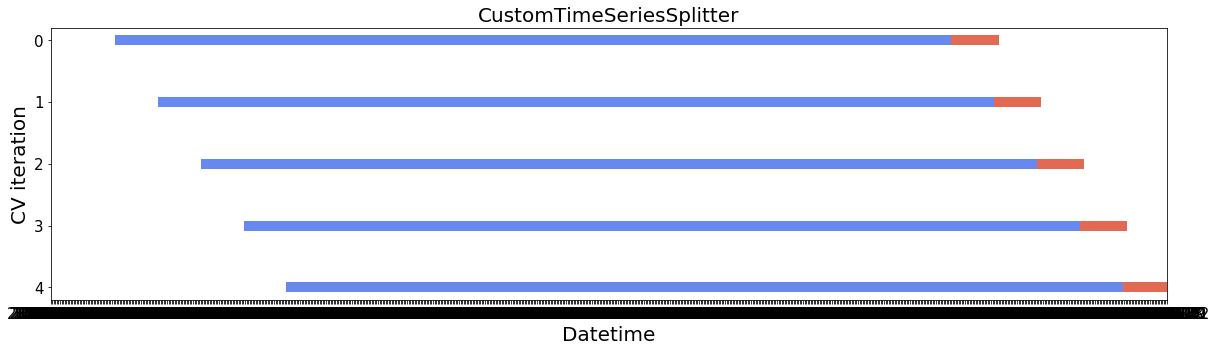

In [10]:
sample = data.iloc[::1000][[day_col, dt_col]].reset_index(drop=True)
show_cv_days(cv, sample, dt_col, day_col)
plot_cv_indices(cv, sample, dt_col)

del sample
gc.collect()

In [11]:
features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t28",
    "shift_t29",
    "shift_t30",
    # std
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    # mean
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    # min
    "rolling_min_t7",
    "rolling_min_t30",
    "rolling_min_t60",
    # max
    "rolling_max_t7",
    "rolling_max_t30",
    "rolling_max_t60",
    # others
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
]

# prepare training and test data.
# 2011-01-29 ~ 2016-04-24 : d_1    ~ d_1913
# 2016-04-25 ~ 2016-05-22 : d_1914 ~ d_1941 (public)
# 2016-05-23 ~ 2016-06-19 : d_1942 ~ d_1969 (private)

is_train = data["d"] < 1914

# Attach "d" to X_train for cross validation.
X_train = data[is_train][[day_col] + features].reset_index(drop=True)
y_train = data[is_train]["demand"].reset_index(drop=True)
X_test = data[~is_train][features].reset_index(drop=True)

# keep these two columns to use later.
id_date = data[~is_train][["id", "date"]].reset_index(drop=True)

del data
gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (21434470, 46)
X_test shape: (853720, 45)


In [12]:
X_train["item_id"] = X_train["item_id"].astype('category')
X_test["item_id"] = X_test["item_id"].astype('category')

In [13]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(
            X_trn.drop(drop_when_train, axis=1).values.astype(np.float32),
            label=y_trn,
        )
        val_set = lgb.Dataset(
            X_val.drop(drop_when_train, axis=1).values.astype(np.float32),
            label=y_val,
        )

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [14]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 0,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)

del X_train, y_train
gc.collect()


----- Fold: (1 / 5) -----

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.26754	valid's rmse: 2.32838
[200]	train's rmse: 2.21734	valid's rmse: 2.31477
Early stopping, best iteration is:
[213]	train's rmse: 2.21281	valid's rmse: 2.31306

----- Fold: (2 / 5) -----

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.21563	valid's rmse: 2.2186
[200]	train's rmse: 2.16583	valid's rmse: 2.2099
Early stopping, best iteration is:
[176]	train's rmse: 2.17686	valid's rmse: 2.20916

----- Fold: (3 / 5) -----

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.19425	valid's rmse: 2.33713
Early stopping, best iteration is:
[99]	train's rmse: 2.19537	valid's rmse: 2.33549

----- Fold: (4 / 5) -----

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.19081	valid's rmse: 2.26627
[200]	train's rmse: 2.14295	valid's rmse: 2.26071
Early stopping, best iteration is:
[157]	t

22

In [15]:
imp_type = "gain"
importances = np.zeros(X_test.shape[1])
preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)
    importances += model.feature_importance(imp_type)

preds = preds / cv.get_n_splits()
importances = importances / cv.get_n_splits()

In [16]:
def make_submission(test, submission):
    preds = test[["id", "date", "demand"]]
    preds = preds.pivot(index="id", columns="date", values="demand").reset_index()
    preds.columns = ["id"] + ["F" + str(d + 1) for d in range(DAYS_PRED)]

    vals = submission[["id"]].merge(preds, how="inner", on="id")
    evals = submission[submission["id"].str.endswith("evaluation")]
    final = pd.concat([vals, evals])

    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])

    final.to_csv("submission1.csv", index=False)

In [17]:
make_submission(id_date.assign(demand=preds), submission)